# Exploración — Ejercicio 1 (Anomalías de Precio)

Este notebook realiza:
- Carga y validación básica del dataset
- Exploración de distribución de precios
- Estadística por `ITEM_ID` (cantidad de registros, rango de precios)
- Visualización de 2–3 productos
- Proporción de anomalías bajo criterio robusto (MAD)


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# Ajusta si quieres cargar desde src/config.py
DATA_PATH = r"C:\\Users\\eidlarme\\Downloads\\20250922_DesafioTecnicoMELI (1) (2) (1)\\precios_historicos.csv"

DATE_COL = "ORD_CLOSED_DT"
ITEM_COL = "ITEM_ID"
PRICE_COL = "PRICE"

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

print('Exists?', os.path.exists(DATA_PATH))
print('File size (MB):', round(os.path.getsize(DATA_PATH)/1024/1024, 2) if os.path.exists(DATA_PATH) else None)

Exists? True
File size (MB): 5.54


In [2]:
# Carga
df = pd.read_csv(DATA_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL])

df.head()

,ITEM_ID,ORD_CLOSED_DT,PRICE
0,MLB4432316952,2024-02-15,22.0100
1,MLB4432316952,2024-03-02,19.8090
2,MLB4432316952,2024-02-16,22.0100
3,MLB4432316952,2024-03-08,23.8134
4,MLB4432316952,2024-02-22,19.0990


In [3]:
# Chequeos rápidos
print('Shape:', df.shape)
print('Nulls:\n', df.isna().sum())
print('Dtypes:\n', df.dtypes)

print('\nMin/Max date:', df[DATE_COL].min(), df[DATE_COL].max())
print('PRICE min/max:', df[PRICE_COL].min(), df[PRICE_COL].max())

Shape: (175914, 3)
Nulls:
 ITEM_ID          0
ORD_CLOSED_DT    0
PRICE            0
dtype: int64
Dtypes:
 ITEM_ID                  object
ORD_CLOSED_DT    datetime64[ns]
PRICE                   float64
dtype: object

Min/Max date: 2023-12-13 00:00:00 2024-03-11 00:00:00
PRICE min/max: 1.9241 5466.29


## Distribución global de precios

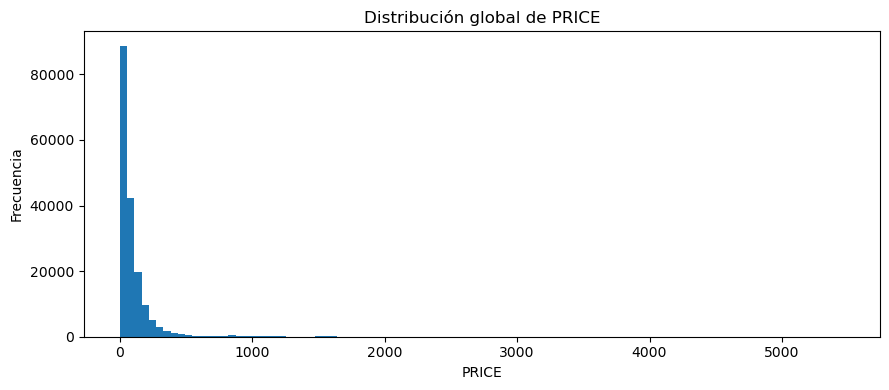

In [4]:
plt.figure(figsize=(9,4))
plt.hist(df[PRICE_COL], bins=100)
plt.title('Distribución global de PRICE')
plt.xlabel('PRICE')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

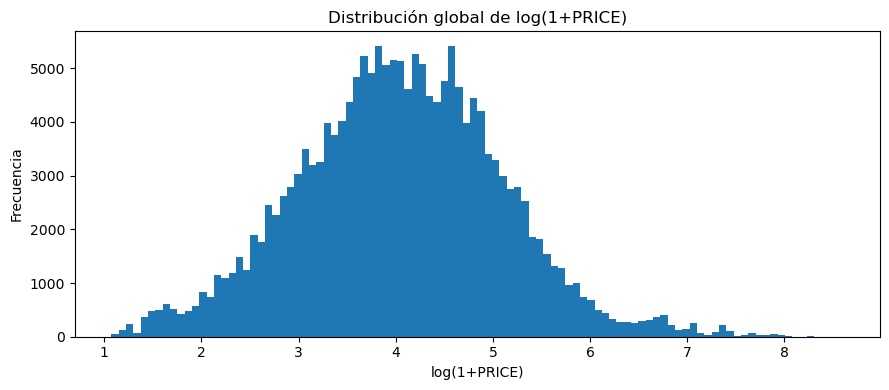

In [5]:
# Distribución log (útil si hay cola larga)
plt.figure(figsize=(9,4))
plt.hist(np.log1p(df[PRICE_COL]), bins=100)
plt.title('Distribución global de log(1+PRICE)')
plt.xlabel('log(1+PRICE)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

## Estadística por ITEM_ID
Cuántos registros por producto y rangos de precios.

In [6]:
stats_item = (df.groupby(ITEM_COL)
              .agg(n=(PRICE_COL,'size'),
                   min_price=(PRICE_COL,'min'),
                   p25=(PRICE_COL, lambda x: x.quantile(0.25)),
                   median=(PRICE_COL,'median'),
                   p75=(PRICE_COL, lambda x: x.quantile(0.75)),
                   max_price=(PRICE_COL,'max'))
              .reset_index()
             )

stats_item.sort_values('n', ascending=False).head(10)

,ITEM_ID,n,min_price,p25,median,p75,max_price
210,MLB3836655204,96448,1.9241,22.4786,47.49900,98.25690,2067.8253
212,MLB3836681004,48709,3.3299,31.7086,61.56410,116.51100,3118.6892
211,MLB3836669552,2949,4.9700,117.2849,206.75200,335.97200,1260.3991
191,MLB3687444228,251,123.5329,124.9600,130.64000,135.32955,148.3829
190,MLB3687430524,198,123.5329,124.9600,128.08755,130.85300,144.5773
24,MLB2173579748,191,88.9275,90.4185,92.12250,94.78500,106.5000
226,MLB4015013082,190,23.0040,23.8489,24.72220,25.33990,26.1919
9,MLB1813853929,189,35.6207,42.0746,45.82340,47.17950,56.3456
163,MLB3533718393,185,4.9700,7.6680,8.16500,8.73300,11.5304
167,MLB3544186473,183,35.9970,40.8179,41.93260,43.15380,49.6290


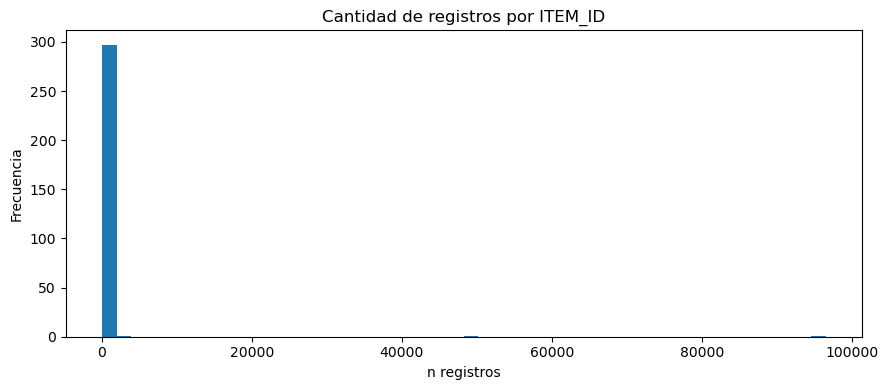

In [7]:
plt.figure(figsize=(9,4))
plt.hist(stats_item['n'], bins=50)
plt.title('Cantidad de registros por ITEM_ID')
plt.xlabel('n registros')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

## Ground truth proxy (MAD z-score)
Definimos anomalías por producto usando estadística robusta.

In [8]:
THRESHOLD_Z = 3.0

df2 = df.copy()
df2['z_mad'] = np.nan
df2['label_gt'] = 'NORMAL'

for item, g in df2.groupby(ITEM_COL):
    med = g[PRICE_COL].median()
    mad = np.median(np.abs(g[PRICE_COL] - med)) + 1e-9
    z = 0.6745 * (g[PRICE_COL] - med) / mad
    df2.loc[g.index, 'z_mad'] = z
    df2.loc[g.index, 'label_gt'] = np.where(np.abs(z) > THRESHOLD_Z, 'ANOMALO', 'NORMAL')

df2['label_gt'].value_counts(normalize=True)

label_gt
NORMAL     0.917045
ANOMALO    0.082955
Name: proportion, dtype: float64

## Visualización de 3 productos ejemplo
Se marcan anomalías según el criterio robusto.

In [9]:
example_items = df2[ITEM_COL].unique()[:3]
example_items

array(['MLB4432316952', 'MLB4413219062', 'MLB4392733324'], dtype=object)

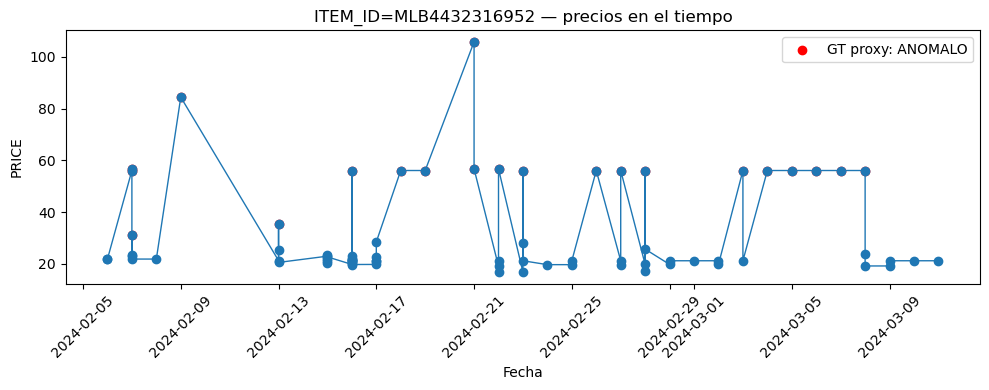

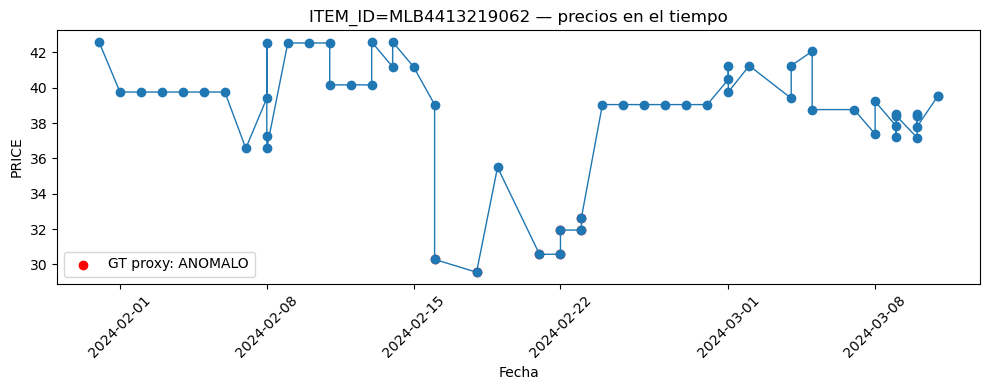

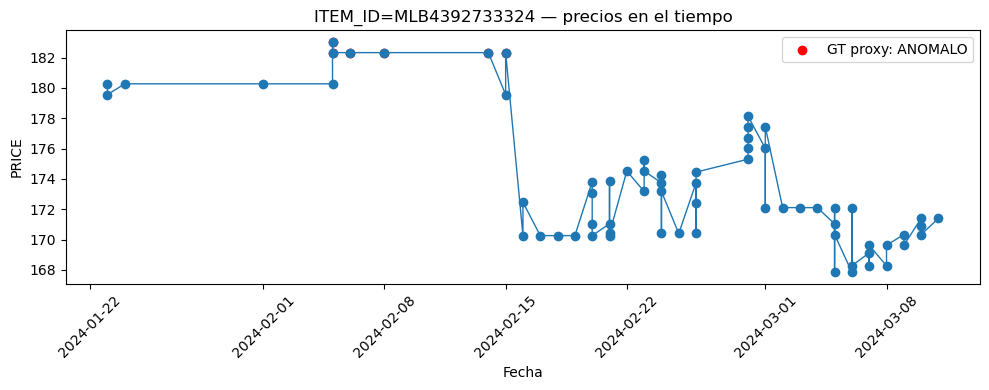

In [10]:
for item in example_items:
    sub = df2[df2[ITEM_COL] == item].sort_values(DATE_COL)
    anom = sub[sub['label_gt'] == 'ANOMALO']

    plt.figure(figsize=(10,4))
    plt.plot(sub[DATE_COL], sub[PRICE_COL], marker='o', linewidth=1)
    if len(anom) > 0:
        plt.scatter(anom[DATE_COL], anom[PRICE_COL], color='red', label='GT proxy: ANOMALO')
    plt.title(f'ITEM_ID={item} — precios en el tiempo')
    plt.xlabel('Fecha')
    plt.ylabel('PRICE')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()